In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from surprise import SVD, Dataset, Reader
import warnings
warnings.filterwarnings("ignore")


In [2]:
netflix_dataset = pd.read_csv("combined_data_1.txt", header=None, names=["Cust_Id","Rating"], usecols=[0,1])
print(netflix_dataset.head())


   Cust_Id  Rating
0       1:     NaN
1  1488844     3.0
2   822109     5.0
3   885013     4.0
4    30878     4.0


In [3]:
df_nan = pd.DataFrame(pd.isnull(netflix_dataset.Rating))
df_nan = df_nan[df_nan['Rating'] == True]

movie_np = []
movie_id = 1

for i, j in zip(df_nan.index[1:], df_nan.index[:-1]):
    temp = np.full((1, i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

last_record = np.full((1, len(netflix_dataset) - df_nan.index[-1] - 1), movie_id)
movie_np = np.append(movie_np, last_record)

netflix_dataset = netflix_dataset[pd.notnull(netflix_dataset['Rating'])]
netflix_dataset['Movie_Id'] = movie_np.astype(int)

print(netflix_dataset.head())


   Cust_Id  Rating  Movie_Id
1  1488844     3.0         1
2   822109     5.0         1
3   885013     4.0         1
4    30878     4.0         1
5   823519     3.0         1


In [4]:
df_movies = pd.read_csv(
    "movie_titles.csv", encoding="ISO-8859-1",
    header=None, names=['Movie_Id','Year','Name'],
    quotechar='"', on_bad_lines="skip"
)

print("Movies loaded:", df_movies.shape)
print(df_movies.head())


Movies loaded: (17434, 3)
   Movie_Id    Year                          Name
0         1  2003.0               Dinosaur Planet
1         2  2004.0    Isle of Man TT 2004 Review
2         3  1997.0                     Character
3         4  1994.0  Paula Abdul's Get Up & Dance
4         5  2004.0      The Rise and Fall of ECW


In [7]:
from scipy.sparse import csr_matrix

# Step 1: Get unique movies and users
unique_movies = netflix_dataset['Movie_Id'].unique()
unique_users = netflix_dataset['Cust_Id'].unique()

print("Unique movies:", len(unique_movies))
print("Unique users:", len(unique_users))

# Step 2: Create mapping dicts (NumPy-based, lighter than category conversion)
movie_id_to_index = {mid: idx for idx, mid in enumerate(unique_movies)}
index_to_movie_id = {idx: mid for idx, mid in enumerate(unique_movies)}

user_id_to_index = {uid: idx for idx, uid in enumerate(unique_users)}
index_to_user_id = {idx: uid for idx, uid in enumerate(unique_users)}

# Step 3: Build sparse ratings matrix (Movies × Users)
row_idx = netflix_dataset['Movie_Id'].map(movie_id_to_index)
col_idx = netflix_dataset['Cust_Id'].map(user_id_to_index)
data = netflix_dataset['Rating']

sparse_matrix = csr_matrix((data, (row_idx, col_idx)), 
                           shape=(len(unique_movies), len(unique_users)))

print("Sparse matrix shape (Movies × Users):", sparse_matrix.shape)
print("Stored values (ratings):", sparse_matrix.nnz)

Unique movies: 4499
Unique users: 470758
Sparse matrix shape (Movies × Users): (4499, 470758)
Stored values (ratings): 24053764


In [8]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Step 1: Dimensionality reduction on sparse matrix
svd_reducer = TruncatedSVD(n_components=50, random_state=42)
rating_features = svd_reducer.fit_transform(sparse_matrix)

print("Rating feature matrix shape:", rating_features.shape)

# Step 2: Add Year info (aligned with movie index order)
# Convert movie_id → index mapping into a DataFrame
df_movies_filtered = df_movies[df_movies['Movie_Id'].isin(unique_movies)]

# Reindex years to follow movie_id_to_index order
years = df_movies_filtered.set_index('Movie_Id').reindex(
    [index_to_movie_id[i] for i in range(len(index_to_movie_id))]
)['Year'].fillna(0).values.reshape(-1, 1)

# Step 3: Normalize year to [0,1]
year_scaler = MinMaxScaler()
year_scaled = year_scaler.fit_transform(years)

print("Year feature shape:", year_scaled.shape)



Rating feature matrix shape: (4499, 50)
Year feature shape: (4499, 1)


In [9]:
# Combine latent rating features + year into final representation
movie_features = np.hstack([rating_features, year_scaled])

print("Final movie feature matrix:", movie_features.shape)




Final movie feature matrix: (4499, 51)


In [35]:
movie_features

array([[ 4.98783594e+00, -7.00471131e-03, -3.93045582e+00, ...,
        -2.43922229e-01,  8.70708711e-01,  9.99002494e-01],
       [ 8.97890974e-01,  3.24258400e-01, -2.77706797e-01, ...,
        -1.63163077e-02,  2.69850348e-01,  9.99501247e-01],
       [ 1.38422811e+01,  1.91553409e+01,  2.36902466e+00, ...,
         5.43808790e-01,  2.52880997e+00,  9.96009975e-01],
       ...,
       [ 5.64557185e+00,  4.72685151e+00, -4.39061618e+00, ...,
         4.47901082e-01,  1.64530928e+00,  9.92518703e-01],
       [ 1.55366423e+00,  1.52855019e+00, -1.04609897e+00, ...,
         4.26217404e-01,  2.71169723e-02,  9.97506234e-01],
       [ 2.27230096e+00,  2.86733303e+00, -4.35007200e-01, ...,
        -2.71625738e-01,  6.65453122e-01,  9.98503741e-01]])

In [26]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, algorithm="elkan")
movie_genres = kmeans.fit_predict(movie_features)

# Map back to Movie_Id
movie_genre_df = pd.DataFrame({
    "Movie_Id": [index_to_movie_id[i] for i in range(len(index_to_movie_id))],
    "Genre": movie_genres,
    "Year": years.flatten()
})

print(movie_genre_df.head())


   Movie_Id  Genre    Year
0         1      0  2003.0
1         2      0  2004.0
2         3      0  1997.0
3         4      0  1994.0
4         5      0  2004.0


In [27]:
df_with_genres = netflix_dataset.merge(movie_genre_df, on="Movie_Id")

print("Dataset with genres:", df_with_genres.shape)
df_with_genres.head()


Dataset with genres: (24053764, 5)


,Cust_Id,Rating,Movie_Id,Genre,Year
0,1488844,3.0,1,0,2003.0
1,822109,5.0,1,0,2003.0
2,885013,4.0,1,0,2003.0
3,30878,4.0,1,0,2003.0
4,823519,3.0,1,0,2003.0


In [28]:
genre_popularity = df_with_genres.groupby("Genre")['Rating'].count().sort_values(ascending=False)
genre_avg_rating = df_with_genres.groupby("Genre")['Rating'].mean().sort_values(ascending=False)

print("Most Popular Genres:\n", genre_popularity)
print("\nBest Liked Genres:\n", genre_avg_rating)


Most Popular Genres:
 Genre
4    6847117
2    5480628
0    4907752
1    4306124
3    2512143
Name: Rating, dtype: int64

Best Liked Genres:
 Genre
1    3.803068
3    3.753253
2    3.604687
4    3.559003
0    3.393550
Name: Rating, dtype: float64


In [29]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split

# Step 1: Sample manageable chunk
sampled_ratings = netflix_dataset.sample(n=500_000, random_state=42)

# Step 2: Define reader + dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(sampled_ratings[['Cust_Id', 'Movie_Id', 'Rating']], reader)

# Step 3: Train-test split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Step 4: Train SVD model
svd = SVD(n_factors=50, random_state=42)
svd.fit(trainset)

# Count ratings in trainset
num_ratings = sum(1 for _ in trainset.all_ratings())
print("Model trained on sample:", num_ratings, "ratings")



Model trained on sample: 400000 ratings


In [30]:
def recommend_per_genre(user_id, svd_model, movie_genre_df, top_n=1):
    """
    Recommend top N movies for a given user across each genre cluster.
    """
    recommendations = []

    for genre_id in sorted(movie_genre_df["Genre"].unique()):
        # Movies belonging to this genre
        genre_movies = movie_genre_df[movie_genre_df["Genre"] == genre_id]["Movie_Id"].values
        
        # Predict ratings for this user on all movies in this genre
        preds = [(mid, svd_model.predict(user_id, mid).est) for mid in genre_movies]
        
        # Pick top N movies in this genre
        top_movies = sorted(preds, key=lambda x: x[1], reverse=True)[:top_n]
        
        for mid, score in top_movies:
            recommendations.append({"Genre": genre_id, "Movie_Id": mid, "Predicted_Rating": score})
    
    return pd.DataFrame(recommendations)

# Example: Recommend 1 movie per genre for a user
example_user = sampled_ratings["Cust_Id"].iloc[0]
user_recs = recommend_per_genre(example_user, svd, movie_genre_df, top_n=1)

print(user_recs.head())


   Genre  Movie_Id  Predicted_Rating
0      0      4427          4.527076
1      1      3938          4.275357
2      2      1144          4.101157
3      3      3371          4.050832
4      4      2162          4.503905


In [31]:
# Merge ratings with genres
ratings_with_genres = sampled_ratings.merge(movie_genre_df, on="Movie_Id")

# Compute mean rating per genre
genre_ratings = ratings_with_genres.groupby("Genre")["Rating"].mean().reset_index()

best_genre = genre_ratings.loc[genre_ratings["Rating"].idxmax()]
worst_genre = genre_ratings.loc[genre_ratings["Rating"].idxmin()]

print("Best Genre (highest avg rating):", best_genre.to_dict())
print("Worst Genre (lowest avg rating):", worst_genre.to_dict())


Best Genre (highest avg rating): {'Genre': 1.0, 'Rating': 3.8052293424213643}
Worst Genre (lowest avg rating): {'Genre': 0.0, 'Rating': 3.3864081089542895}


Distribution of Ratings per Genre

<Figure size 1000x600 with 0 Axes>

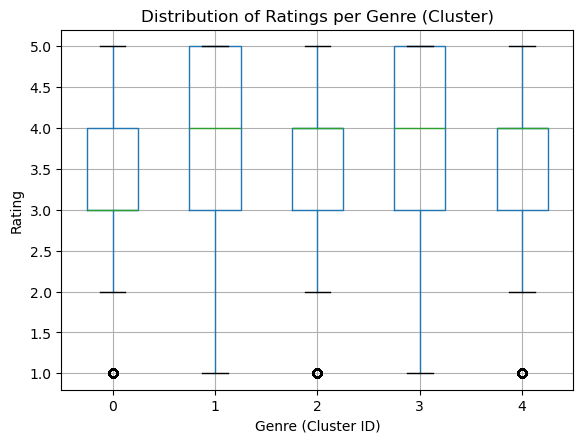

'\nTaller boxes → more variation in opinions.\n\nHigher medians → genres users generally enjoy more.\n\nOutliers → movies rated very differently from the trend.\n'

In [32]:
import matplotlib.pyplot as plt

# Merge ratings with genres
ratings_with_genres = sampled_ratings.merge(movie_genre_df, on="Movie_Id")

plt.figure(figsize=(10,6))
ratings_with_genres.boxplot(column="Rating", by="Genre")
plt.title("Distribution of Ratings per Genre (Cluster)")
plt.suptitle("")  # remove extra title
plt.xlabel("Genre (Cluster ID)")
plt.ylabel("Rating")
plt.show()


'''
Taller boxes → more variation in opinions.

Higher medians → genres users generally enjoy more.

Outliers → movies rated very differently from the trend.
'''

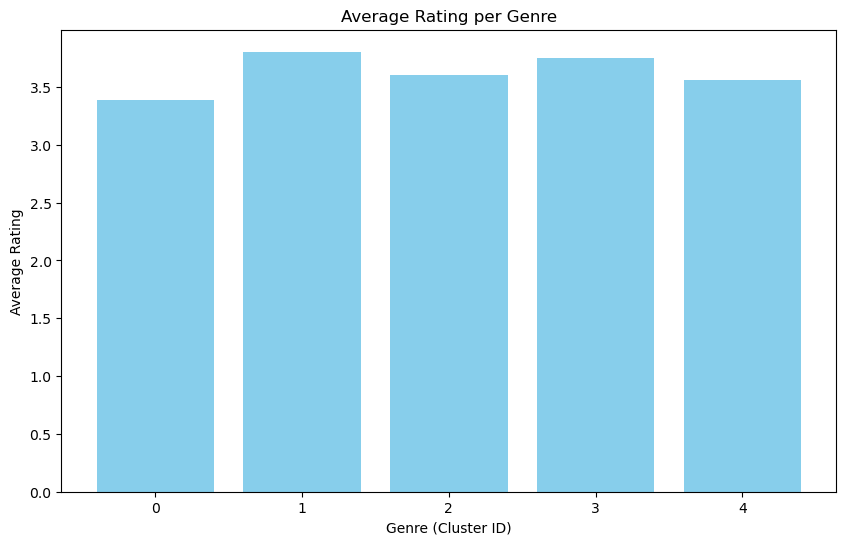

'\nAverage Rating per Genre (Bar Plot)\n'

In [33]:
genre_ratings = ratings_with_genres.groupby("Genre")["Rating"].mean().reset_index()

plt.figure(figsize=(10,6))
plt.bar(genre_ratings["Genre"], genre_ratings["Rating"], color="skyblue")
plt.title("Average Rating per Genre")
plt.xlabel("Genre (Cluster ID)")
plt.ylabel("Average Rating")
plt.show()
'''
Average Rating per Genre (Bar Plot)
'''

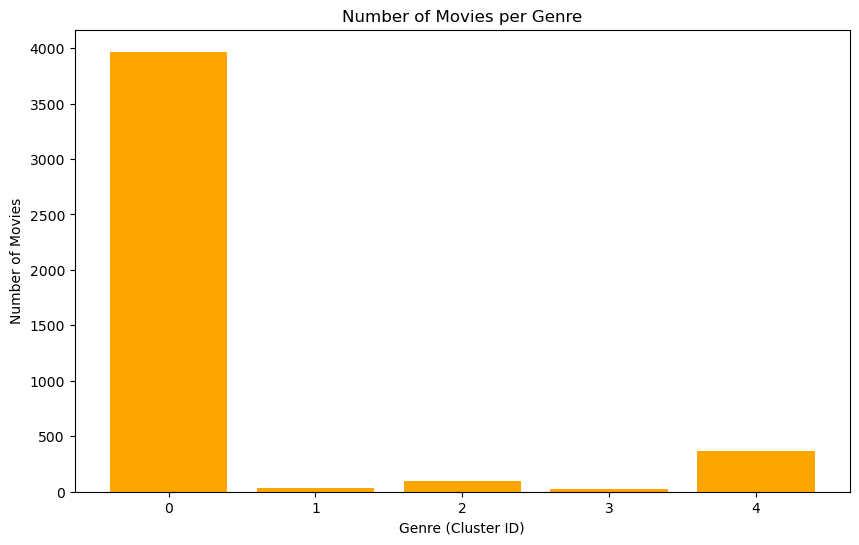

'\nNumber of Movies per Genre\n'

In [34]:
movie_counts = movie_genre_df["Genre"].value_counts().sort_index()

plt.figure(figsize=(10,6))
plt.bar(movie_counts.index, movie_counts.values, color="orange")
plt.title("Number of Movies per Genre")
plt.xlabel("Genre (Cluster ID)")
plt.ylabel("Number of Movies")
plt.show()
'''
Number of Movies per Genre
'''

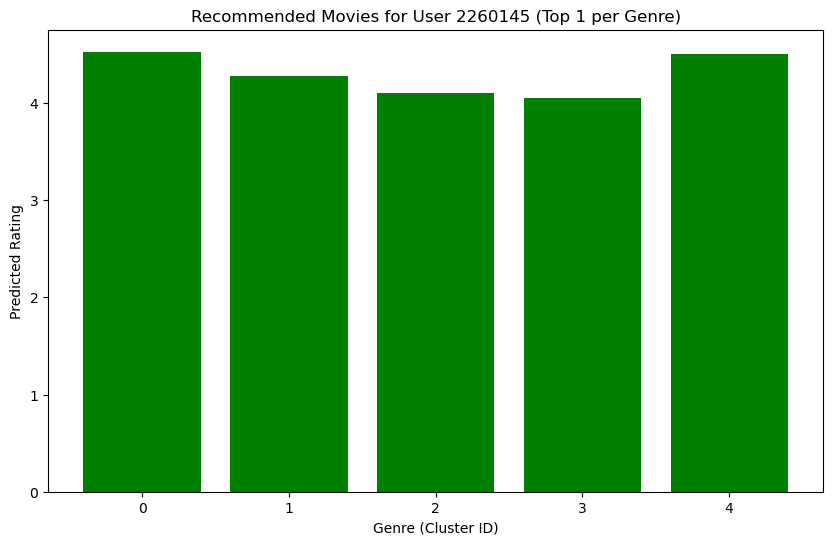

In [36]:
# Example recommendations for one user
user_recs = recommend_per_genre(example_user, svd, movie_genre_df, top_n=1)

plt.figure(figsize=(10,6))
plt.bar(user_recs["Genre"], user_recs["Predicted_Rating"], color="green")
plt.title(f"Recommended Movies for User {example_user} (Top 1 per Genre)")
plt.xlabel("Genre (Cluster ID)")
plt.ylabel("Predicted Rating")
plt.show()
